# TODO

* Add mouse and walking max-d analysis for all data (including CoM)
* Add results of Hartigan's dip test https://www.rdocumentation.org/packages/diptest/versions/0.75-7/topics/dip.test
* Run frequentist regressions with lme4

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Lambda$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 

# What's done:
- Ran mouse max-d without change-of-mind.
- Ran mouse RT for all types.
- Ran walking max-d without change-of-mind.
- Ran walking RT for all types.

Load needed libraries

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

Load processed data

In [2]:
get_processed_data <- function(){
    filename <- "C:/Users/Arkady/Google Drive/data/beyond_the_reach/choices_processed.txt"
#     filename <- "../data/choices_processed.txt"
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])
    data[, 'option_chosen'] <- factor(data[, 'option_chosen'])
    
    return(data)
}

In [3]:
data <- get_processed_data()

In [4]:
nrow(data)/94

[1] 51.53191

Here, I have 2 sets of data for mouse/walking:
one with all trials, one with CoM trials excluded.

In [5]:
data <- get_processed_data()
mouse_data <- data[data$task=='mouse',]


# discarding missing values
mouse_data <- mouse_data[complete.cases(mouse_data[ , 'max_d']),]
mouse_data_no_com <- mouse_data[mouse_data$is_com=='False',]

walking_data <- data[data$task=='walking',]
walking_data <- walking_data[complete.cases(walking_data[ , 'max_d']),]
walking_data_no_com <- walking_data[walking_data$is_com=='False',]

In [6]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter))
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior)
    }
    return(model)
}

run_analysis <- function(var, data, rscale){
    " This function runs our analysis for a particular dataset (fake or real) and given DV (var).
    The rscale parameter defines the scale of prior distribution on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, var])/sd(data[, 'Lambda'])), class = "b"))

    formulas <- list(f_inter = as.formula(paste(var, "~ (option_chosen | subj_id) + Lambda:option_chosen")),
                     f_choice = as.formula(paste(var, "~ (option_chosen | subj_id)")),
                     f_null = as.formula(paste(var, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    return(bf_result)
}

# Mouse data: max-d without change-of-mind

In [7]:
max_d_bf <- run_analysis('max_d', mouse_data_no_com, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 24.757 seconds (Warm-up)
               20.117 seconds (Sampling)
               44.874 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 17.278 seconds (Warm-up)
               13.641 seconds (Sampling)
               30.919 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 5.216 seconds (Warm-up)
               3.74 seconds (Sampling)
               8.956 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust yo

In [8]:
max_d_bf$bf

1.718594e+58,1.284491e+56,0.006757469


In [9]:
spaghetti <- function(model, var, ylabel){
    plt_dat <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=800), plot=FALSE)
    plt_dat <- plt_dat$"Lambda:option_chosen" + 
#         geom_point(aes_string(x="Lambda", y=var, shape='choice', colour='choice'), size = 3, alpha=0.6, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX('Advantage of LL option ($\\lambda$)')) +
        ylab(ylabel) +
        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)

    plot(plt_dat)
#     ggsave(sprintf('figures/spaghetti_%s.png', var), dpi=300) 
}

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


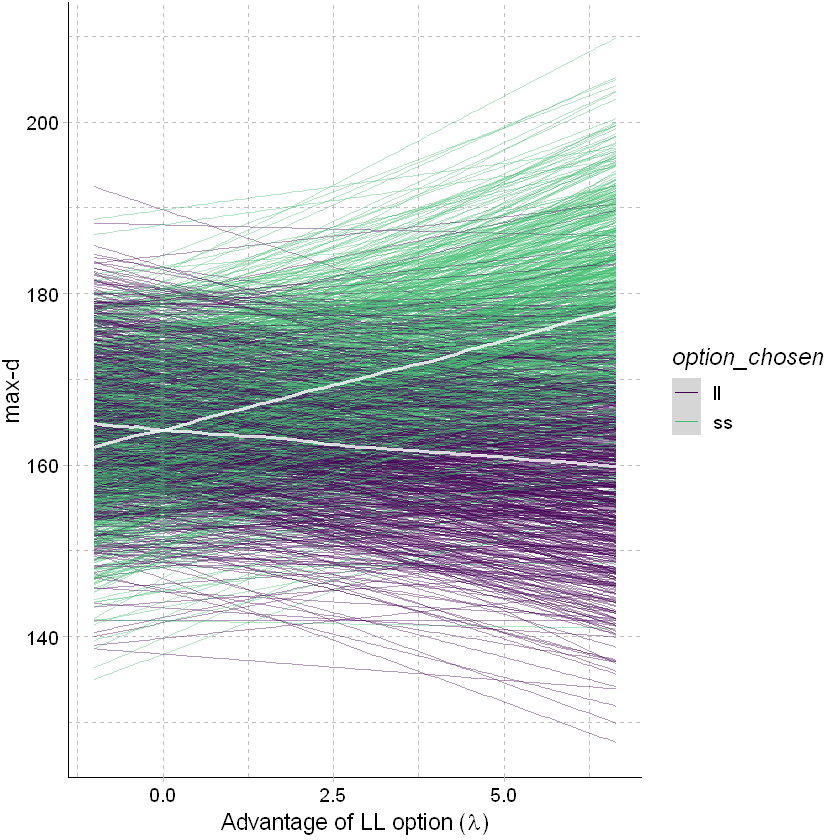

In [10]:
# spaghetti(rt_bf$models$m_inter, 'RT', 'RT')
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

In [23]:
m <- as.mcmc(max_d_bf$models$m_inter, combine_chains = FALSE)
matrix_m <- as.matrix(m)
coeffs<-colMeans(as.matrix(matrix_m))
write.csv(coeffs, file = "csv/max_d_coeffs_mouse_no_com.csv")
mcmc_areas_ridges(matrix_m[,order(colMeans(matrix_m))], regex_pars = ",option_chosen", prob=0.95) 

# Mouse data: RT

In [25]:
rt_bf <- run_analysis('RT', mouse_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 32.812 seconds (Warm-up)
               40.001 seconds (Sampling)
               72.813 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 19.964 seconds (Warm-up)
               9.991 seconds (Sampling)
               29.955 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
A

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 4.629 seconds (Warm-up)
               4.516 seconds (Sampling)
               9.145 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

In [26]:
rt_bf$bf

68895713,1.655643e+19,243316333854


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


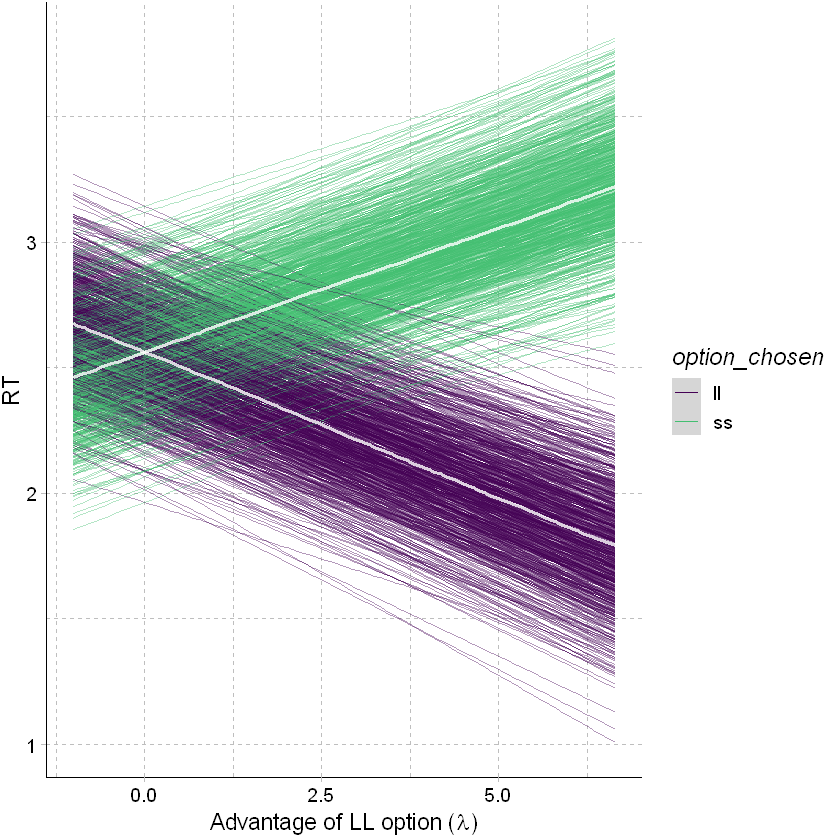

In [27]:
spaghetti(rt_bf$models$m_inter, 'RT', 'RT')

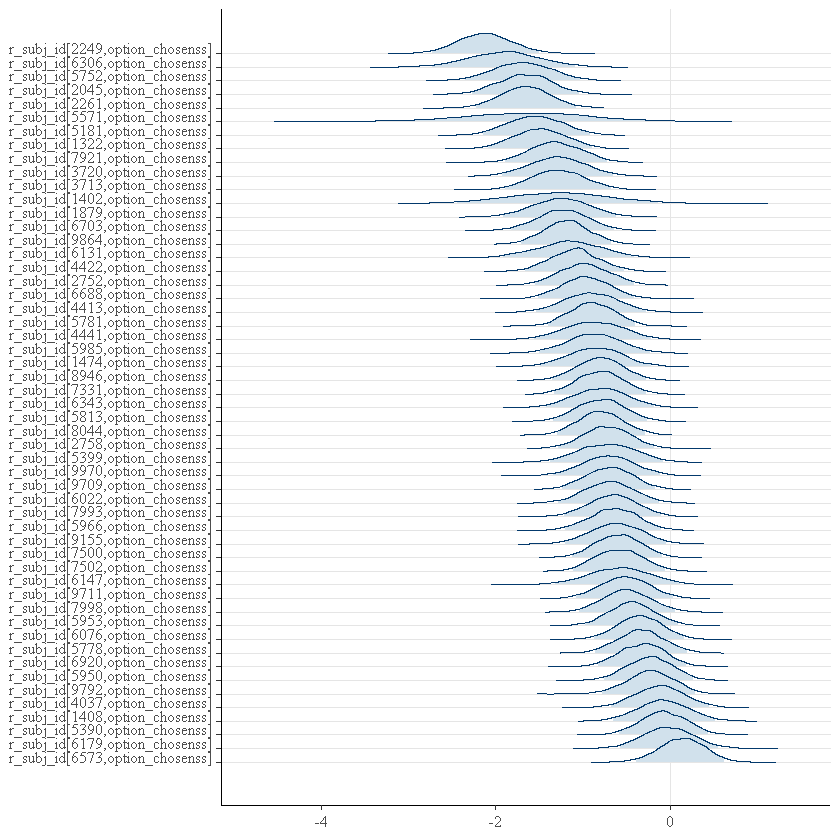

In [28]:
m <- as.mcmc(rt_bf$models$m_inter, combine_chains = FALSE)
matrix_m <- as.matrix(m)
coeffs<-colMeans(as.matrix(matrix_m))
write.csv(coeffs, file = "RT_mouse_all_coeffs.csv")
mcmc_areas_ridges(matrix_m[,order(colMeans(matrix_m))], regex_pars = ",option_chosen", prob=0.95) 

# Walking data: max-d without CoM

In [29]:
max_d_bf <- run_analysis('max_d', walking_data_no_com, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 40.16 seconds (Warm-up)
               24.706 seconds (Sampling)
               64.866 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 26.951 seconds (Warm-up)
               20.334 seconds (Sampling)
               47.285 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0.016 seconds
1000 transitions using 10 leapfrog steps per transition would take 160 seconds.

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 8.207 seconds (Warm-up)
               4.421 seconds (Sampling)
               12.628 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust 

In [32]:
#     bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_null)$bf,
#               bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
max_d_bf$bf

5.971211e+58,7.23663e+65,9984027


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


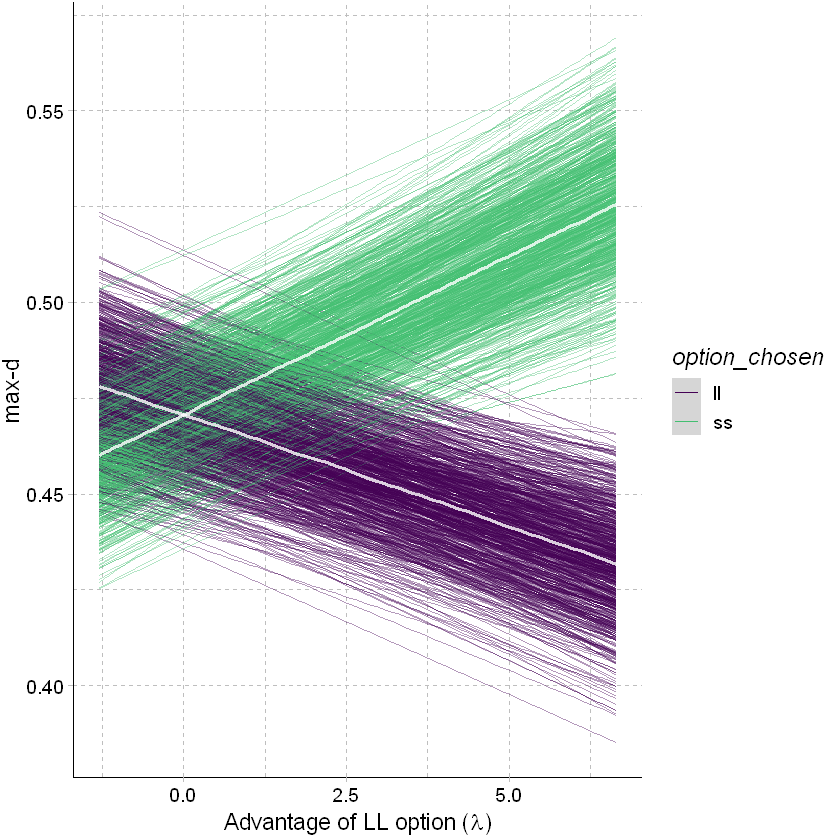

In [33]:
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

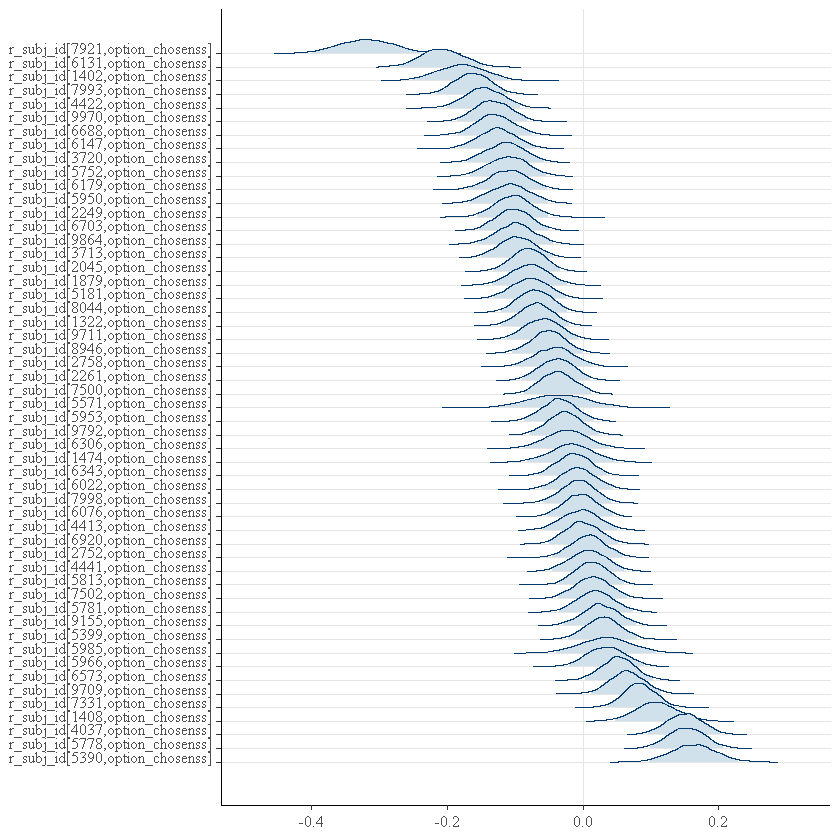

In [34]:
m <- as.mcmc(max_d_bf$models$m_inter, combine_chains = FALSE)
matrix_m <- as.matrix(m)
coeffs<-colMeans(as.matrix(matrix_m))
write.csv(coeffs, file = "max_d_coeffs_walking_no_com.csv")
mcmc_areas_ridges(matrix_m[,order(colMeans(matrix_m))], regex_pars = ",option_chosen", prob=0.95) 

# Walking data: RT

In [23]:
rt_bf <- run_analysis('RT', walking_data, 0.707)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 38.096 seconds (Warm-up)
               34.507 seconds (Sampling)
               72.603 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

Warning message:
"There were 2 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 41.394 seconds (Warm-up)
               27.079 seconds (Sampling)
               68.473 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.


Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.024 seconds
1000 transitions using 10 leapfrog steps per transition would take 240 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 10.813 seconds (Warm-up)
               8.259 seconds (Sampling)
               19.072 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.


In [24]:
rt_bf$bf

341448598329,1.843921e+16,63458.58


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


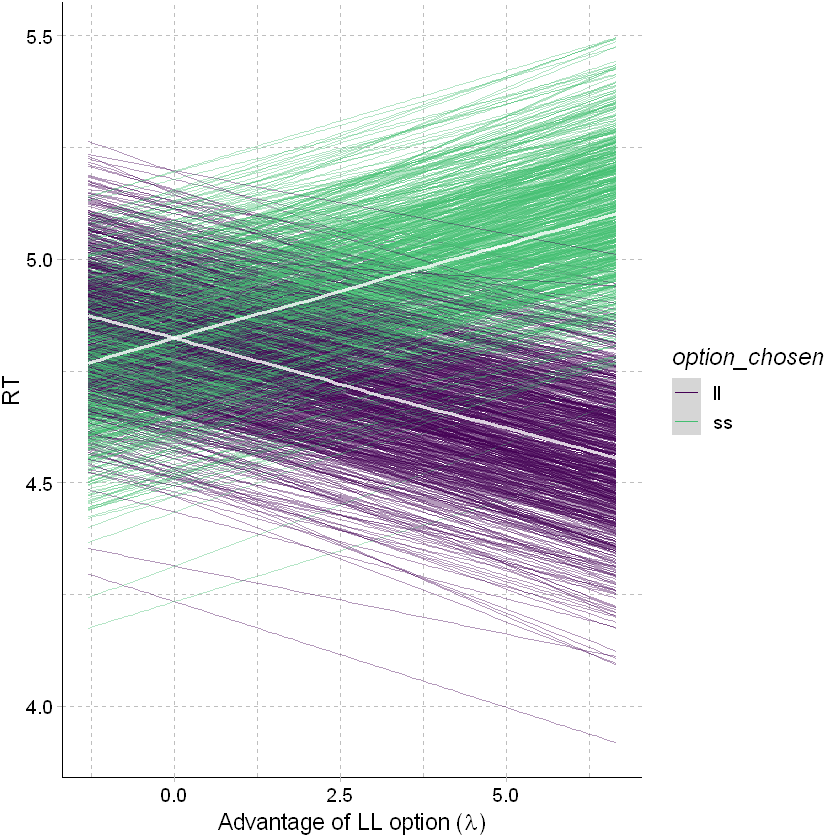

In [25]:
spaghetti(rt_bf$models$m_inter, 'RT', 'RT')

In [26]:
m <- as.mcmc(rt_bf$models$m_inter, combine_chains = FALSE)
matrix_m <- as.matrix(m)
coeffs<-colMeans(as.matrix(matrix_m))
write.csv(coeffs, file = "RT_walking_all_coeffs.csv")
mcmc_areas_ridges(matrix_m[,order(colMeans(matrix_m))], regex_pars = ",option_chosen", prob=0.95) 

In [28]:
# hpd_inter<-HPDinterval(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE))

# mcmc_areas_ridges(as.matrix(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE)), regex_pars = "b_Lambda", prob=0.95)
# hpd_inter[c('b_Lambda:choiceLL', 'b_Lambda:choiceSS'),]